In [ ]:
# %pip install fastai
# %pip install duckduckgo_search 

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search # It's a good idea to ensure you're running the latest version of any libraries you need.

## Download images of people with various emotions

In [3]:
from duckduckgo_search import DDGS
from fastcore.all import L

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max_images)
    return L(results).itemgot('image')

Let's start by searching for a happy emotion photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [4]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('bird photo', max_images=1)
urls[0]

Searching for 'bird photo'


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

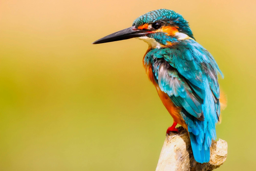

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'parrot'


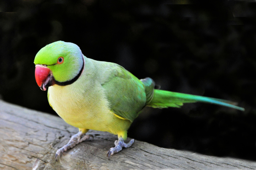

In [6]:
download_url(search_images('parrot', max_images=1)[0], 'bird2.jpg', show_progress=False)
Image.open('bird2.jpg').to_thumb(256,256)

Downloading different images to train the model

In [7]:
searches = 'parrot','Budgerigar','owl','Columbidae','blue jay','hummingbird','penguins','crow', 'falcon', 'stork'
path = Path('birds')
from time import sleep

for bird in searches:
    dest = (path/bird)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{bird} photo', max_images=50))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{bird} photo flying', max_images=50))
    sleep(10)
    download_images(dest, urls=search_images(f'{bird} in nature', max_images=50))
    sleep(10)
    resize_images(path/bird, max_size=400, dest=path/bird)

Searching for 'parrot photo'
Searching for 'parrot photo flying'
Searching for 'parrot in nature'
Searching for 'Budgerigar photo'
Searching for 'Budgerigar photo flying'
Searching for 'Budgerigar in nature'
Searching for 'owl photo'
Searching for 'owl photo flying'
Searching for 'owl in nature'
Searching for 'Columbidae photo'
Searching for 'Columbidae photo flying'
Searching for 'Columbidae in nature'
Searching for 'blue jay photo'
Searching for 'blue jay photo flying'
Searching for 'blue jay in nature'
Searching for 'hummingbird photo'
Searching for 'hummingbird photo flying'
Searching for 'hummingbird in nature'
Searching for 'penguins photo'
Searching for 'penguins photo flying'
Searching for 'penguins in nature'
Searching for 'crow photo'
Searching for 'crow photo flying'
Searching for 'crow in nature'
Searching for 'falcon photo'
Searching for 'falcon photo flying'
Searching for 'falcon in nature'
Searching for 'stork photo'
Searching for 'stork photo flying'
Searching for 'stor

## Training the model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

61

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it

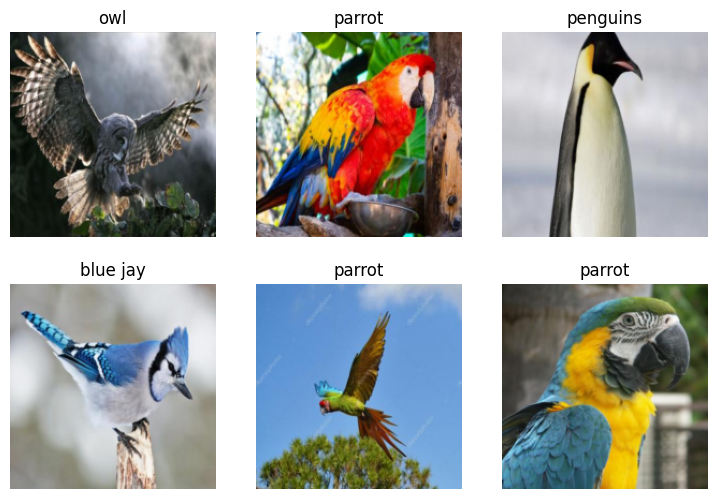

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5) # here the number is the number of epochs 

epoch,train_loss,valid_loss,error_rate,time
0,1.818057,0.365153,0.114391,01:03


epoch,train_loss,valid_loss,error_rate,time
0,0.390412,0.290656,0.110701,01:49
1,0.241322,0.270324,0.081181,01:32
2,0.156095,0.235484,0.081181,01:25
3,0.100248,0.221761,0.066421,01:20
4,0.067029,0.203550,0.070111,01:22


## Using the model

Searching for 'bird photos'


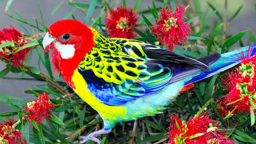

In [26]:
download_url(search_images('bird photos', max_images=150)[148], 'test.jpg', show_progress=False)
Image.open('test.jpg').to_thumb(256,256)

In [27]:
from fastai.vision.all import PILImage

# Predict the bird
bird, _, probs = learn.predict(PILImage.create('test.jpg'))

# Find the index with the highest probability
highest_prob_idx = probs.argmax()

# Retrieve the corresponding category
highest_prob_category = learn.dls.vocab[highest_prob_idx]

if(probs[highest_prob_idx] > 0.5000):
    # Print the predicted bird
    print(f"This is a: {bird}.")

    # Print the highest probability category and its probability
    print(f"Category with highest probability: {highest_prob_category} with probability {probs[highest_prob_idx]:.4f}")

else: 
    print("Not considered for the classification")
    
# Print all probabilities for reference
for idx, prob in enumerate(probs):
    print(f"Probability of {learn.dls.vocab[idx]}: {prob:.4f}")

This is a: parrot.
Category with highest probability: parrot with probability 0.9077
Probability of Budgerigar: 0.0337
Probability of Columbidae: 0.0000
Probability of blue jay: 0.0003
Probability of crow: 0.0001
Probability of falcon: 0.0000
Probability of hummingbird: 0.0571
Probability of owl: 0.0011
Probability of parrot: 0.9077
Probability of penguins: 0.0000
Probability of stork: 0.0000
